# Classification

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
data_folder = 'C:/Users/matte/RockPaperScissorsData'

data_folder_pixel = data_folder + "/pixel_csv"
data_folder_landmarks = data_folder + "/landmarks_csv"
data_folder_distances = data_folder + "/distances_csv"
data_folder_aug_pixel = data_folder + "/augmented_pixel_csv"
data_folder_aug_landmarks = data_folder + "/augmented_landmarks_csv"

In [12]:
techniques_folder = [data_folder_pixel, data_folder_landmarks,data_folder_distances,
              data_folder_aug_pixel, data_folder_aug_landmarks]

In [13]:
techniques = ['pixel', 'landmarks', 'distances', 'aug_pixel', 'aug_landm', 'aug_pix_pca']

## Load Datasets

In [14]:
df_list = []
for tech in techniques_folder:
    df_rock = pd.read_csv(tech + '/rock.csv', header=None)
    df_paper = pd.read_csv(tech + '/paper.csv', header=None)
    df_scissors = pd.read_csv(tech + '/scissors.csv', header=None)
    
    df_rock_target = df_rock.assign(target=np.full((len(df_rock), 1), 'rock'));
    df_paper_target = df_paper.assign(target=np.full((len(df_paper), 1), 'paper'));
    df_scissors_target = df_scissors.assign(target=np.full((len(df_scissors), 1), 'scissors'));
    
    df = pd.concat([df_rock_target, df_paper_target, df_scissors_target])
    
    df_list.append(df)

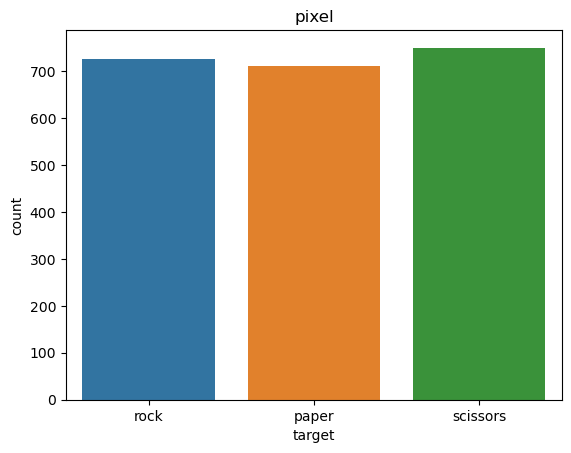

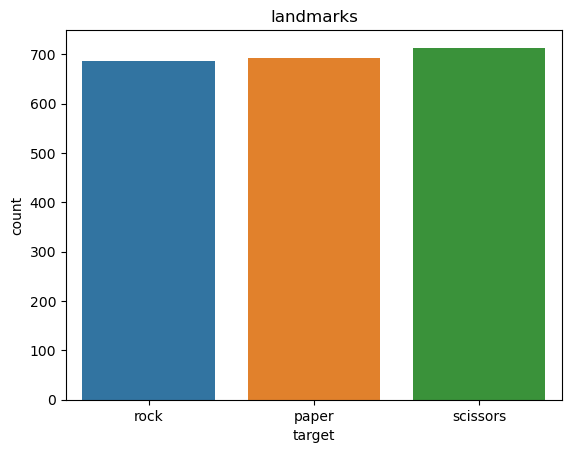

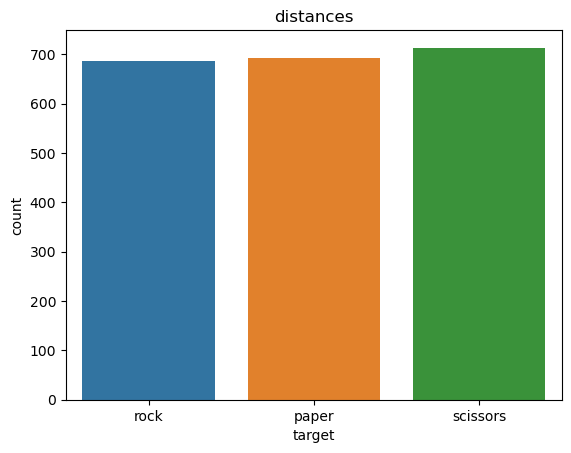

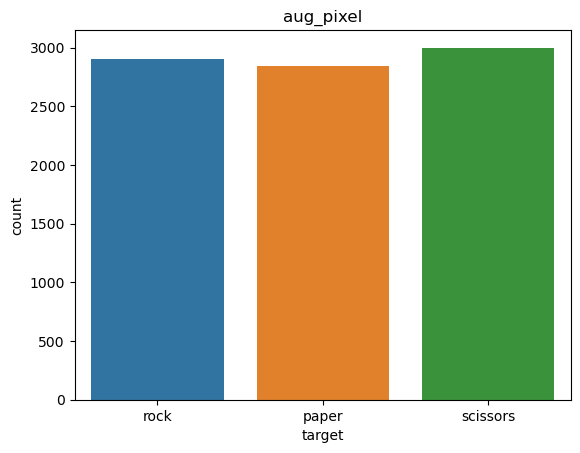

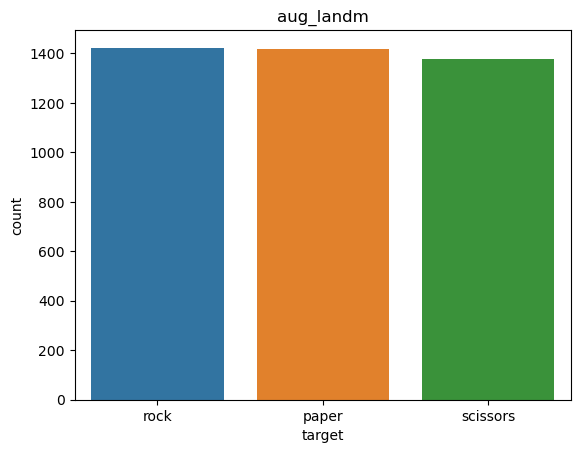

In [15]:
count = 0
for df in df_list:
    sns.countplot(x = 'target', data = df)
    plt.title(techniques[count])
    plt.show()
    count = count + 1

We can see from the graphs that all 5 datasets created are quite balanced

# Classifiers

In [16]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from statistics import mean

In [17]:
X_list = []
y_list = []
for df in df_list:
    X_list.append(df.drop(columns = ["target"]))
    y_list.append(df.target)

### PCA on Pixel-DataSet

Since there are 625 many features, it might be convenient to apply a Principal Component Analysis to reduce them.

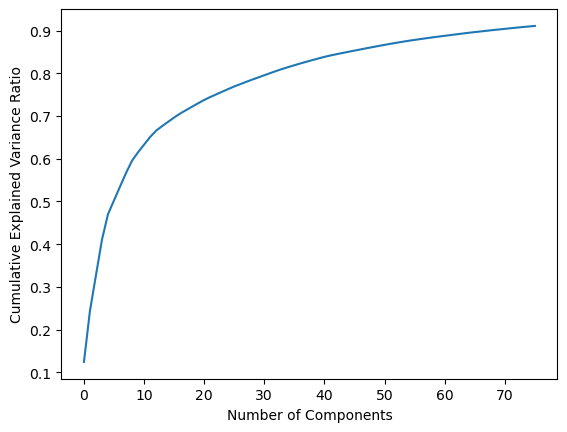

In [10]:
df = X_list[3].copy()

pca = PCA(n_components = 0.91)
principal_components = pca.fit_transform(df)

cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

By plotting the Cumulative Explained Variance Ratio as the number of components varies, we see that with 70 components an explained variance greater than 90% is reached. So I decide to use this number of features in the pipeline

### Defining Cross-Validation

I decided to evaluate different classifiers for each dataset created. To do this I decided to use cross validation with 10 folds.

In [11]:
def test_classifier(clf, X_list, y_list):
    pipe = Pipeline([('clf', clf)])
    pipe_pca = Pipeline([('pca', PCA(n_components = 70)), ('clf', clf)])
    
    kf = KFold(n_splits = 10)
    
    results_list = []
    
    #cross validation
    for count in (range(len(X_list))):
        results = cross_validate(pipe,
                        X_list[count],
                        y_list[count],
                        scoring = { 'f1_scorer': make_scorer(f1_score, average = 'macro'),
                                     'accuracy': make_scorer(accuracy_score)},
                        return_estimator = True,
                        cv = kf,
                        n_jobs = -1)
        
        results_list.append(results)
        
    #cross validation with PCA
    results = cross_validate(pipe_pca,
                        X_list[3],
                        y_list[3],
                        scoring = { 'f1_scorer': make_scorer(f1_score, average = 'macro'),
                                    'accuracy': make_scorer(accuracy_score)},
                        return_estimator = True,
                        cv = kf,
                        n_jobs = -1)
        
    results_list.append(results)
    
    return results_list

def plot_confusion_matrix(clf, X_list, y_list):
    pipe = Pipeline([('clf', clf)])
    pipe_pca = Pipeline([('pca', PCA(n_components = 70)), ('clf', clf)])
    
    kf = KFold(n_splits = 10)
    
    y_pred_list = []
    
    #cross validation
    for count in (range(len(X_list))):
        y_pred = cross_val_predict(pipe,
                        X_list[count],
                        y_list[count],
                        cv = kf,
                        n_jobs = -1)
        
        y_pred_list.append(y_pred)
        
    #cross validation with PCA
    y_pred = cross_val_predict(pipe_pca,
                        X_list[3],
                        y_list[3],
                        cv = kf,
                        n_jobs = -1)
        
    y_pred_list.append(y_pred)
    
    
    new_y_list = y_list[:]
    new_y_list.append(y_list[3])
    
    conf_mat_list = []
    for count in (range(len(y_pred_list))):
        conf_mat = confusion_matrix(new_y_list[count], y_pred_list[count])
        conf_mat_list.append(conf_mat)
        
    count = 0
    for conf_mat in conf_mat_list:
        disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat,
                                display_labels = ['paper', 'rock', 'scissors'])
        print(techniques[count ])
        disp.plot()
        count = count + 1
        plt.show()

def plot_results(results_list):
    
    metrics_accuracy = pd.DataFrame({'pixel': results_list[0]['test_accuracy'],
                        'landmarks': results_list[1]['test_accuracy'],
                        'distances': results_list[2]['test_accuracy'],
                        'aug_pixel': results_list[3]['test_accuracy'],
                        'aug_landm': results_list[4]['test_accuracy'],
                        'aug_pix_pca': results_list[5]['test_accuracy']})
    
    metrics_fscore = pd.DataFrame({'pixel': results_list[0]['test_f1_scorer'],
                        'landmarks': results_list[1]['test_f1_scorer'],
                        'distances': results_list[2]['test_f1_scorer'],
                        'aug_pixel': results_list[3]['test_f1_scorer'],
                        'aug_landm': results_list[4]['test_f1_scorer'],
                        'aug_pix_pca': results_list[5]['test_f1_scorer']})
    
    ax = metrics_accuracy.boxplot(figsize = (8, 3.5))
    ax = metrics_accuracy.boxplot()
    ax.set_ylabel('accuracy')
    plt.show()
    
    ax = metrics_fscore.boxplot(figsize = (8, 3.5))
    ax = metrics_fscore.boxplot()
    ax.set_ylabel('f1_scorer')
    plt.show()
    
    
    print('Mean accuracy scores:')
    print("'pixel': ", mean(metrics_accuracy['pixel']))
    print("'landmarks': ", mean(metrics_accuracy['landmarks']))
    print("'distances': ", mean(metrics_accuracy['distances']))
    print("'aug_pixel': ", mean(metrics_accuracy['aug_pixel']))
    print("'aug_landm': ", mean(metrics_accuracy['aug_landm']))
    print("'aug_pix_pca': ", mean(metrics_accuracy['aug_pix_pca']))
    
    print('\nMean f1 scores:')
    print("'pixel': ", mean(metrics_fscore['pixel']))
    print("'landmarks': ", mean(metrics_fscore['landmarks']))
    print("'distances': ", mean(metrics_fscore['distances']))
    print("'aug_pixel': ", mean(metrics_fscore['aug_pixel']))
    print("'aug_landm': ", mean(metrics_fscore['aug_landm']))
    print("'aug_pix_pca': ", mean(metrics_fscore['aug_pix_pca']))
    
    print('\nMean score time:')
    print("'pixel': ", mean(results_list[0]['score_time']))
    print("'landmarks': ", mean(results_list[1]['score_time']))
    print("'distances': ", mean(results_list[2]['score_time']))
    print("'aug_pixel': ", mean(results_list[3]['score_time']))
    print("'aug_landm': ", mean(results_list[4]['score_time']))
    print("'aug_pix_pca': ", mean(results_list[5]['score_time']))

For each classifier I represent the boxplots of the accuracy and f1 score. Furthermore, I report the confusion matrix to verify if the classifier gets confused between two classes more than the other.

## Decision Tree
### criterion = gini

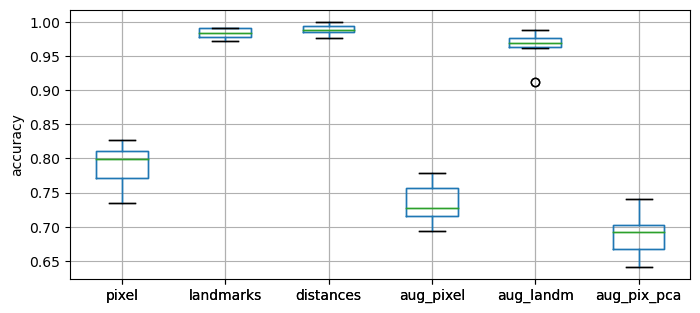

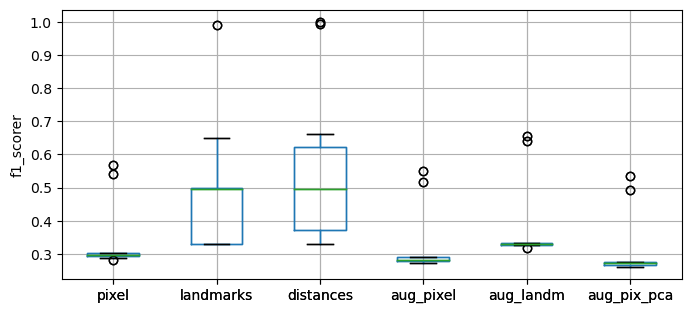

Mean accuracy scores:
'pixel':  0.7916069708013909
'landmarks':  0.9832581453634085
'distances':  0.989002050580998
'aug_pixel':  0.7326386170906719
'aug_landm':  0.966342830768538
'aug_pix_pca':  0.6870454011741682

Mean f1 scores:
'pixel':  0.3465351483038297
'landmarks':  0.49464435986536404
'distances':  0.5635999894086929
'aug_pixel':  0.33100511088293055
'aug_landm':  0.3916377987050869
'aug_pix_pca':  0.3183828563020796

Mean score time:
'pixel':  0.019704318046569823
'landmarks':  0.01070103645324707
'distances':  0.009600996971130371
'aug_pixel':  0.034405755996704104
'aug_landm':  0.01040201187133789
'aug_pix_pca':  0.06240460872650146


In [46]:
from sklearn.tree import DecisionTreeClassifier
decisionTree_gini = DecisionTreeClassifier(criterion = 'gini')

results_list = test_classifier(decisionTree_gini, X_list, y_list);
plot_results(results_list)

pixel


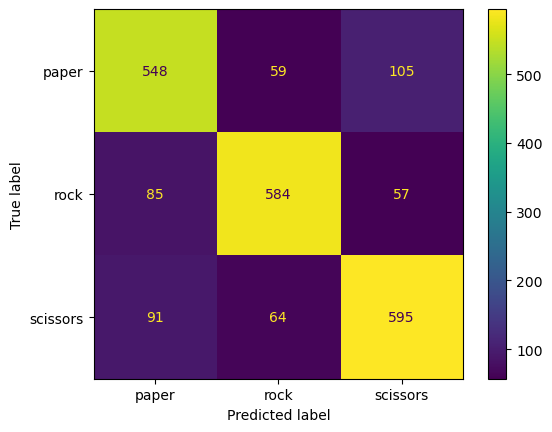

landmarks


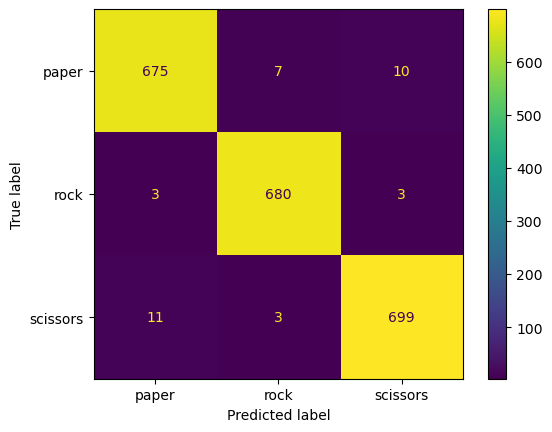

distances


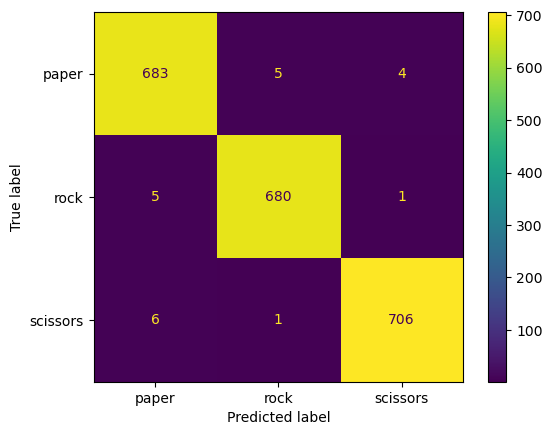

aug_pixel


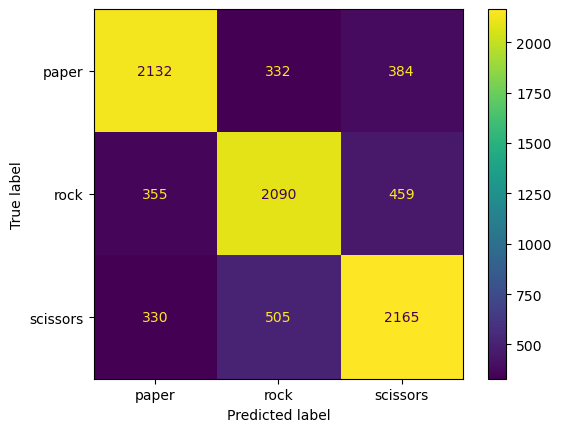

aug_landm


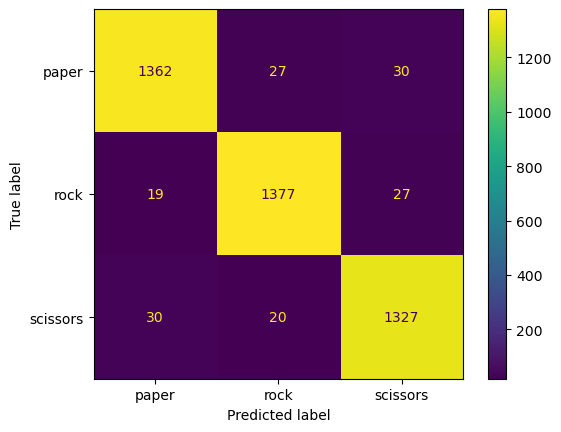

aug_pix_pca


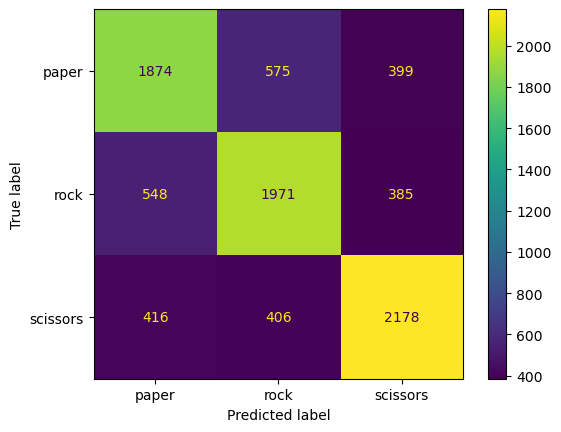

In [12]:
plot_confusion_matrix(decisionTree_gini, X_list, y_list)

## Decision Tree
### criterion = entropy

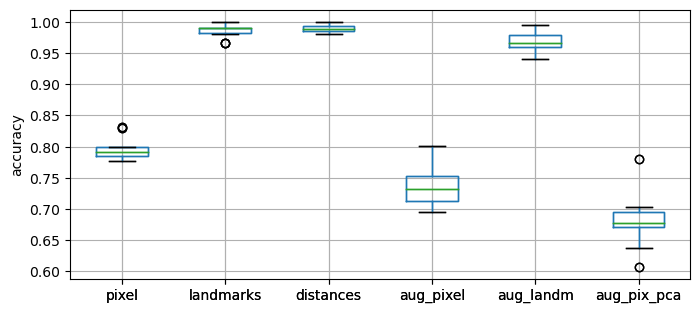

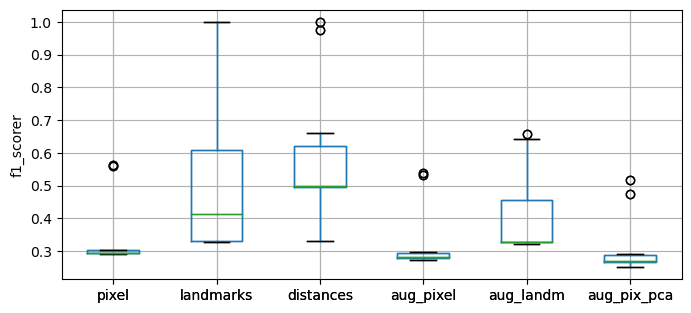

Mean accuracy scores:
'pixel':  0.7970843282644212
'landmarks':  0.9856459330143541
'distances':  0.989002050580998
'aug_pixel':  0.735034703196347
'aug_landm':  0.9682368767659939
'aug_pix_pca':  0.6816819308545335

Mean f1 scores:
'pixel':  0.34898227919467883
'landmarks':  0.5282076186702643
'distances':  0.5787248616913222
'aug_pixel':  0.33200133695487827
'aug_landm':  0.4088008785445922
'aug_pix_pca':  0.3147344254378342

Mean score time:
'pixel':  0.020502114295959474
'landmarks':  0.008600616455078125
'distances':  0.022697877883911134
'aug_pixel':  0.03560385704040527
'aug_landm':  0.00960087776184082
'aug_pix_pca':  0.05430335998535156


In [47]:
from sklearn.tree import DecisionTreeClassifier
decisionTree_entropy = DecisionTreeClassifier(criterion = 'entropy')

results_list = test_classifier(decisionTree_entropy, X_list, y_list);
plot_results(results_list)

pixel


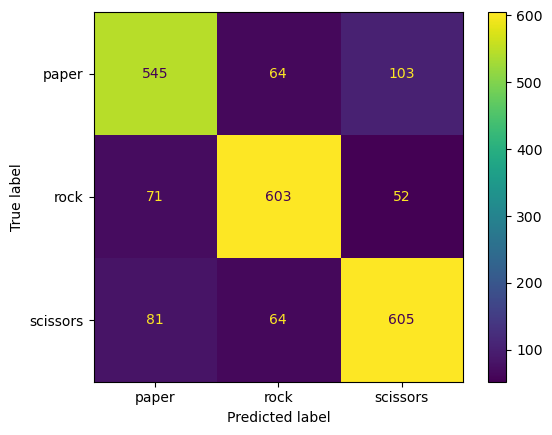

landmarks


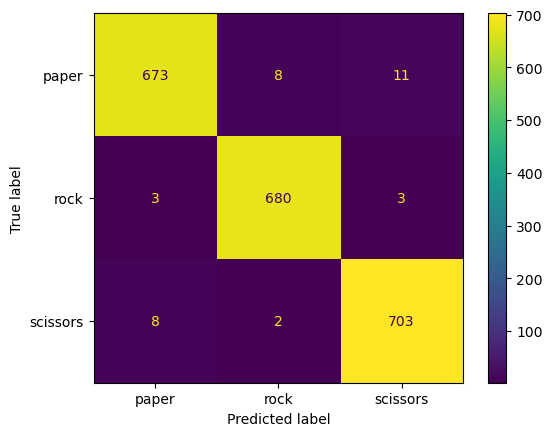

distances


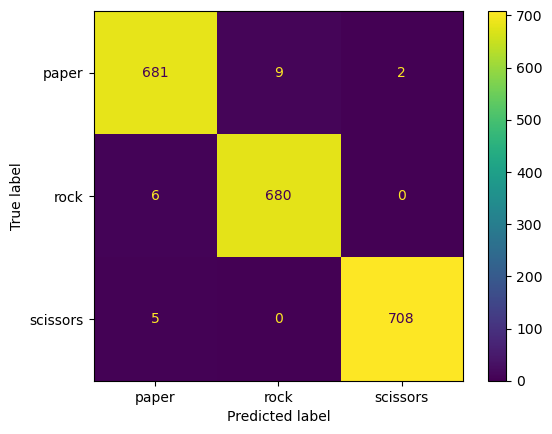

aug_pixel


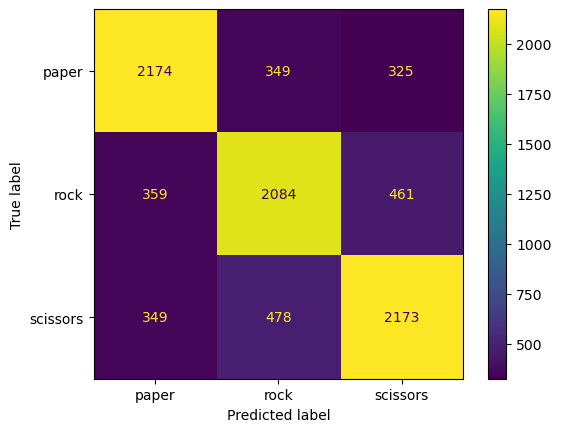

aug_landm


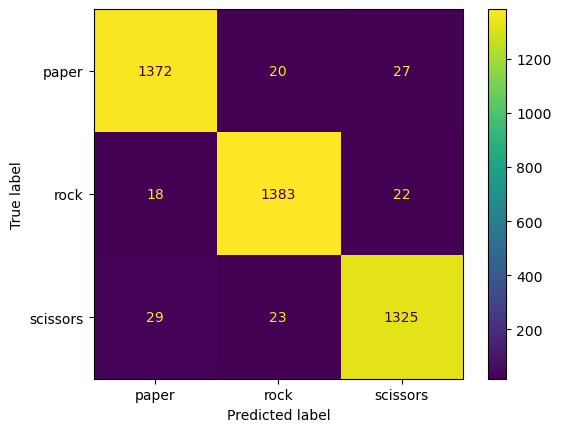

aug_pix_pca


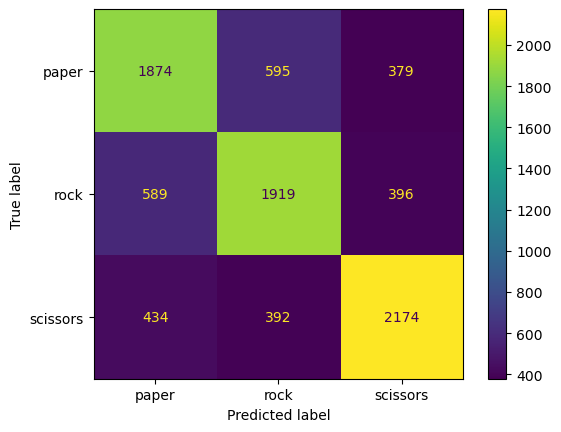

In [16]:
plot_confusion_matrix(decisionTree_entropy, X_list, y_list)

## K-Nearest Neighbor



Test for k =  1


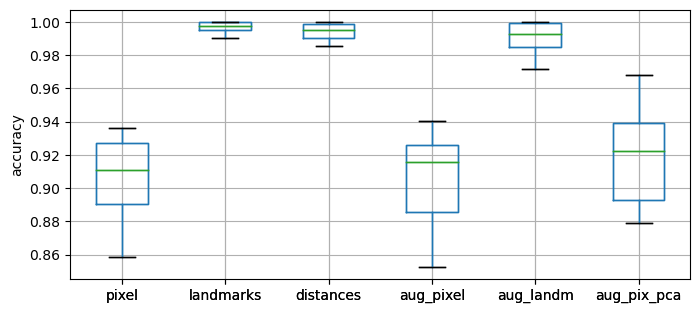

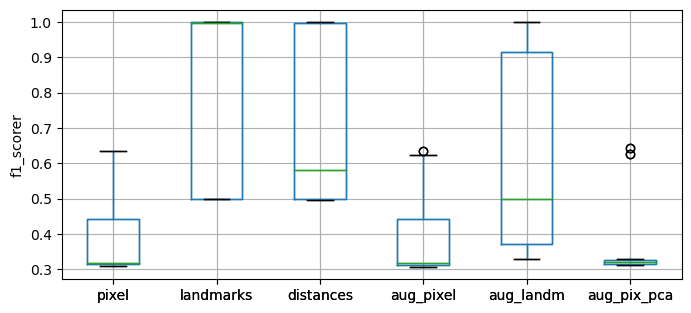

Mean accuracy scores:
'pixel':  0.9081228268610447
'landmarks':  0.9971291866028708
'distances':  0.9942652084757347
'aug_pixel':  0.9057385518590998
'aug_landm':  0.9909913205975391
'aug_pix_pca':  0.9187663405088062

Mean f1 scores:
'pixel':  0.39483283813530623
'landmarks':  0.7988064397702385
'distances':  0.7140601321464922
'aug_pixel':  0.3945146167256424
'aug_landm':  0.6145111108123069
'aug_pix_pca':  0.3812844736018129

Mean score time:
'pixel':  0.19224658012390136
'landmarks':  0.04845278263092041
'distances':  0.03751142024993896
'aug_pixel':  2.4051027059555055
'aug_landm':  0.1582899808883667
'aug_pix_pca':  0.5829507350921631


Test for k =  2


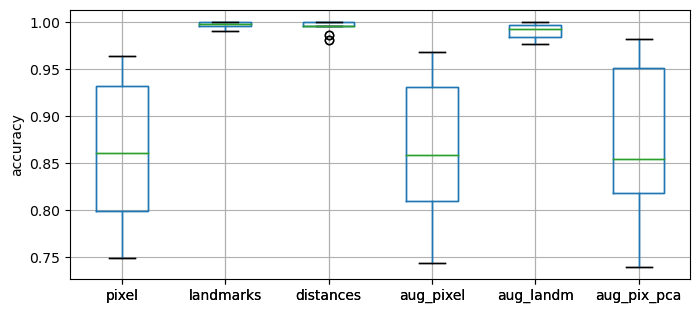

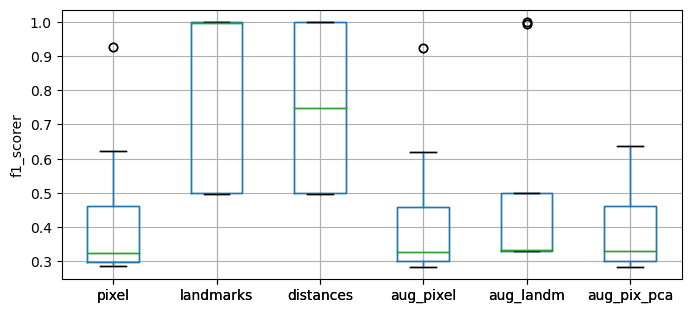

Mean accuracy scores:
'pixel':  0.8596141761970592
'landmarks':  0.9971291866028708
'distances':  0.9947459557985874
'aug_pixel':  0.8610666666666666
'aug_landm':  0.9898053607411827
'aug_pix_pca':  0.8718100456621004

Mean f1 scores:
'pixel':  0.4286766086592189
'landmarks':  0.7988064397702385
'distances':  0.7483032459452661
'aug_pixel':  0.4285574599461005
'aug_landm':  0.49771487605333753
'aug_pix_pca':  0.40158239284134645

Mean score time:
'pixel':  0.20566015243530272
'landmarks':  0.048451685905456544
'distances':  0.03125925064086914
'aug_pixel':  2.631303381919861
'aug_landm':  0.16336960792541505
'aug_pix_pca':  0.6311695814132691


Test for k =  3


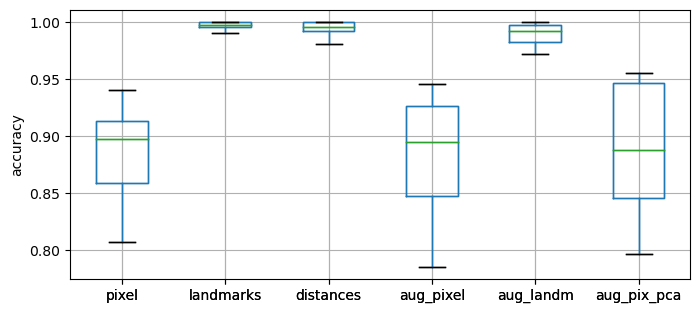

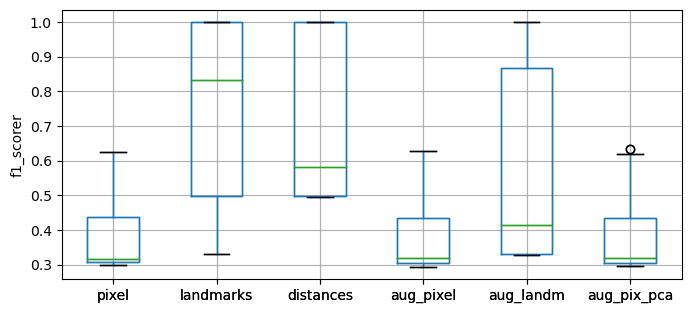

Mean accuracy scores:
'pixel':  0.8843282644212642
'landmarks':  0.9966507177033492
'distances':  0.9942674868990659
'aug_pixel':  0.8836874103065884
'aug_landm':  0.989568956783105
'aug_pix_pca':  0.8902037834311807

Mean f1 scores:
'pixel':  0.38909550932068776
'landmarks':  0.7492488088496747
'distances':  0.7149988049386429
'aug_pixel':  0.38911999615172854
'aug_landm':  0.563796089801573
'aug_pix_pca':  0.39033881188811775

Mean score time:
'pixel':  0.21117813587188722
'landmarks':  0.05157935619354248
'distances':  0.02811279296875
'aug_pixel':  2.7376284837722777
'aug_landm':  0.15976500511169434
'aug_pix_pca':  0.6794565677642822


Test for k =  4


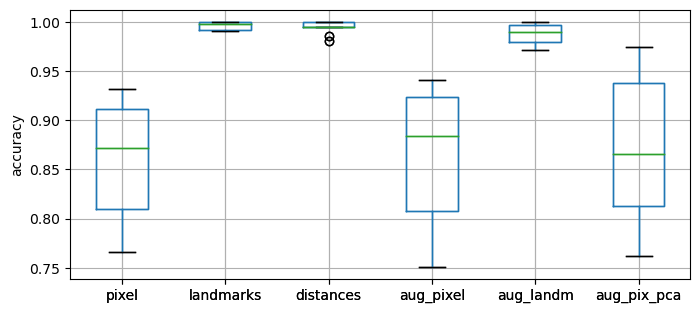

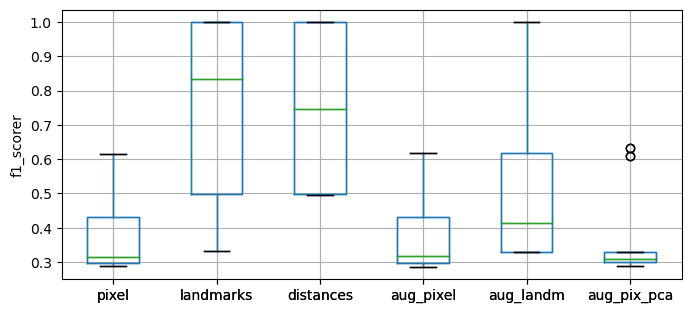

Mean accuracy scores:
'pixel':  0.8573394495412844
'landmarks':  0.9961722488038277
'distances':  0.9947459557985874
'aug_pixel':  0.8596926288323549
'aug_landm':  0.9879096261440263
'aug_pix_pca':  0.8697542074363992

Mean f1 scores:
'pixel':  0.3822184538845831
'landmarks':  0.7491283283110287
'distances':  0.7483032459452661
'aug_pixel':  0.38257566019148104
'aug_landm':  0.5304352151898712
'aug_pix_pca':  0.3696541549067217

Mean score time:
'pixel':  0.20408101081848146
'landmarks':  0.05314061641693115
'distances':  0.03169496059417724
'aug_pixel':  2.7409595966339113
'aug_landm':  0.1922440528869629
'aug_pix_pca':  0.7098310232162476


Test for k =  5


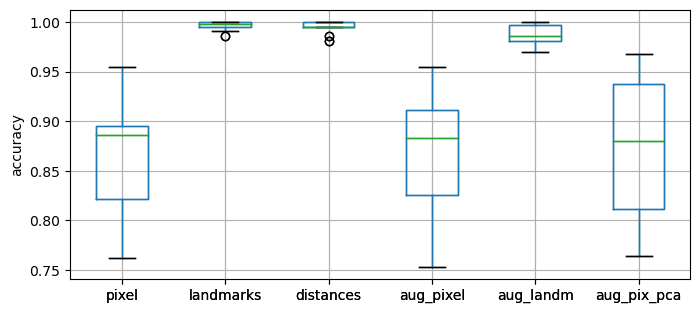

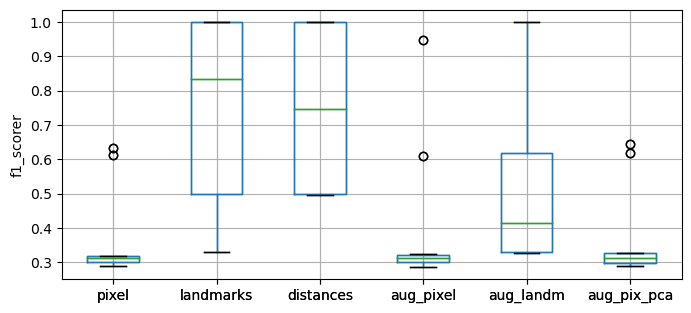

Mean accuracy scores:
'pixel':  0.862372753550333
'landmarks':  0.9961722488038277
'distances':  0.9947459557985874
'aug_pixel':  0.8649458577951729
'aug_landm':  0.9871987256700926
'aug_pix_pca':  0.8727206784083497

Mean f1 scores:
'pixel':  0.36898633597354036
'landmarks':  0.7491681014045094
'distances':  0.7483032459452661
'aug_pixel':  0.4005517129727551
'aug_landm':  0.497051373606799
'aug_pix_pca':  0.37163961153603803

Mean score time:
'pixel':  0.20510754585266114
'landmarks':  0.059708356857299805
'distances':  0.03440282344818115
'aug_pixel':  2.6561081647872924
'aug_landm':  0.1767735242843628
'aug_pix_pca':  0.6526162147521972


Test for k =  6


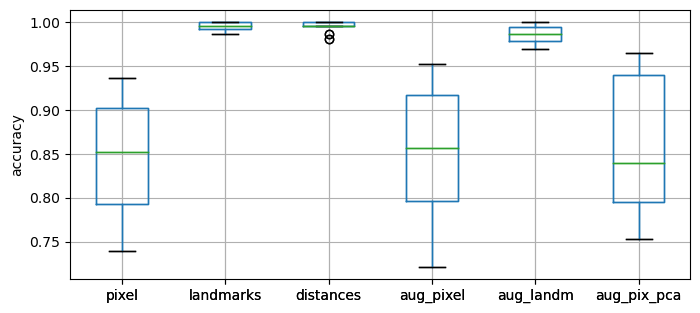

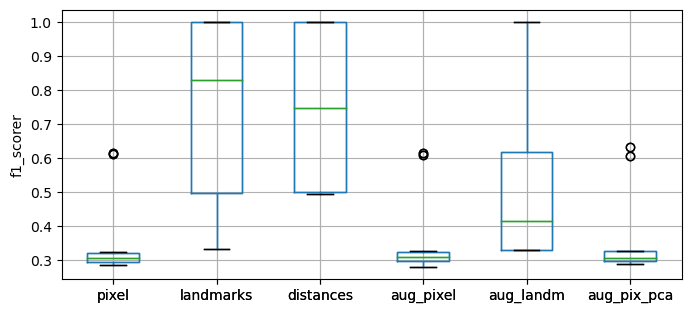

Mean accuracy scores:
'pixel':  0.8472833144820074
'landmarks':  0.9952153110047847
'distances':  0.9947459557985874
'aug_pixel':  0.8487222439660795
'aug_landm':  0.9855399578975808
'aug_pix_pca':  0.8559272015655577

Mean f1 scores:
'pixel':  0.3643660909047961
'landmarks':  0.7485527940552471
'distances':  0.7483032459452661
'aug_pixel':  0.3642933256040206
'aug_landm':  0.49656402370939945
'aug_pix_pca':  0.36670547314949586

Mean score time:
'pixel':  0.22836108207702638
'landmarks':  0.06963207721710205
'distances':  0.0433354377746582
'aug_pixel':  2.6942790508270265
'aug_landm':  0.18940978050231932
'aug_pix_pca':  0.7249600648880005


Test for k =  7


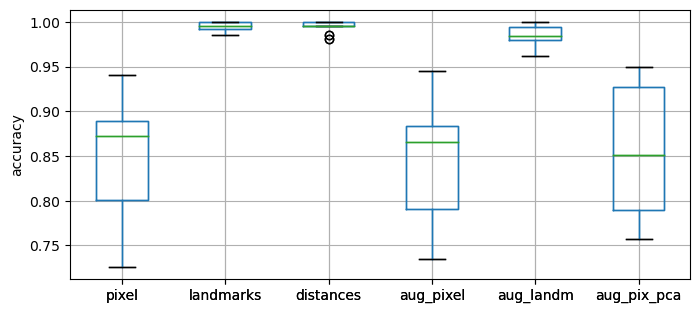

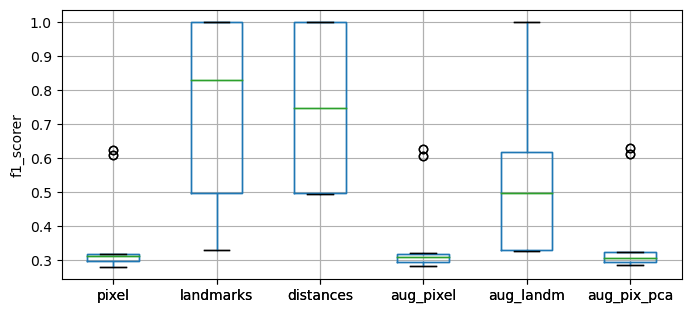

Mean accuracy scores:
'pixel':  0.8491118930920364
'landmarks':  0.9952153110047847
'distances':  0.9947459557985874
'aug_pixel':  0.8471185909980431
'aug_landm':  0.9850660242482917
'aug_pix_pca':  0.8561510763209393

Mean f1 scores:
'pixel':  0.36530637929875204
'landmarks':  0.7485527940552471
'distances':  0.7483032459452661
'aug_pixel':  0.36496725262594293
'aug_landm':  0.5133859623482874
'aug_pix_pca':  0.36691091939741105

Mean score time:
'pixel':  0.218133544921875
'landmarks':  0.06280887126922607
'distances':  0.03725590705871582
'aug_pixel':  2.7041943311691283
'aug_landm':  0.19210259914398192
'aug_pix_pca':  0.6815226316452027


Test for k =  8


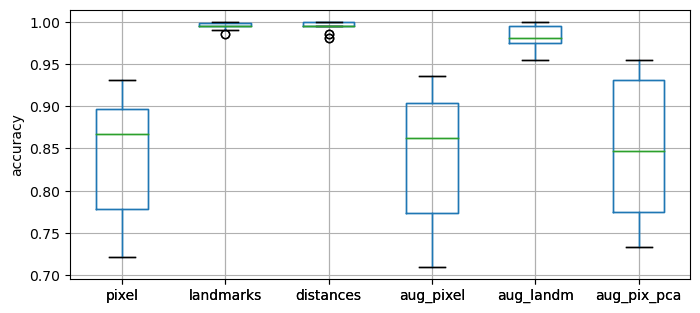

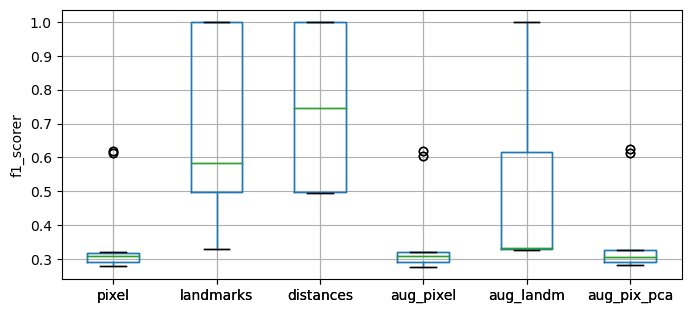

Mean accuracy scores:
'pixel':  0.84177663273428
'landmarks':  0.9952153110047847
'distances':  0.9947459557985874
'aug_pixel':  0.8411767775603392
'aug_landm':  0.9822218594859903
'aug_pix_pca':  0.8487251141552511

Mean f1 scores:
'pixel':  0.3635301664247187
'landmarks':  0.6985533705171545
'distances':  0.7483032459452661
'aug_pixel':  0.36314672974344664
'aug_landm':  0.47935339793010473
'aug_pix_pca':  0.3650253754068494

Mean score time:
'pixel':  0.1950220823287964
'landmarks':  0.051557302474975586
'distances':  0.0312598705291748
'aug_pixel':  2.805634641647339
'aug_landm':  0.20830061435699462
'aug_pix_pca':  0.6893030643463135


Test for k =  9


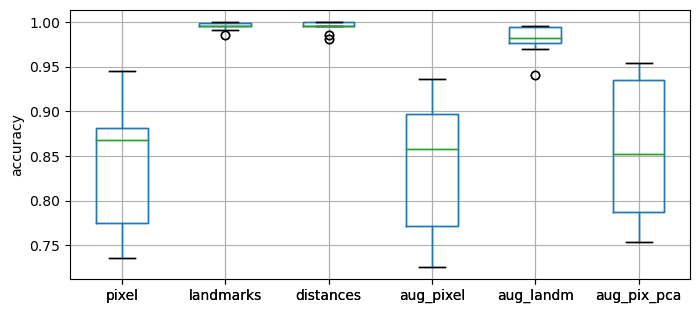

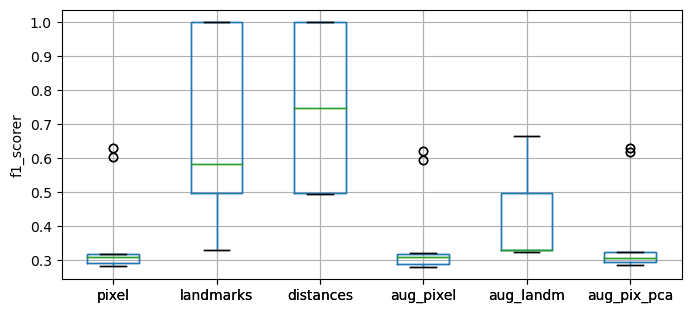

Mean accuracy scores:
'pixel':  0.8427024422939969
'landmarks':  0.9952153110047847
'distances':  0.9947459557985874
'aug_pixel':  0.8400349641226353
'aug_landm':  0.9808006214046898
'aug_pix_pca':  0.8563796477495107

Mean f1 scores:
'pixel':  0.36422076956453403
'landmarks':  0.6985533705171545
'distances':  0.7483032459452661
'aug_pixel':  0.3621843194633497
'aug_landm':  0.42903895669040343
'aug_pix_pca':  0.3673566947923933

Mean score time:
'pixel':  0.19704954624176024
'landmarks':  0.060953950881958006
'distances':  0.0386509895324707
'aug_pixel':  2.6959118127822874
'aug_landm':  0.1853527307510376
'aug_pix_pca':  0.693300199508667


Test for k =  10


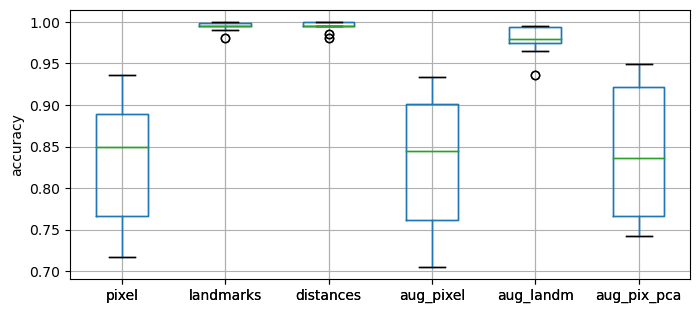

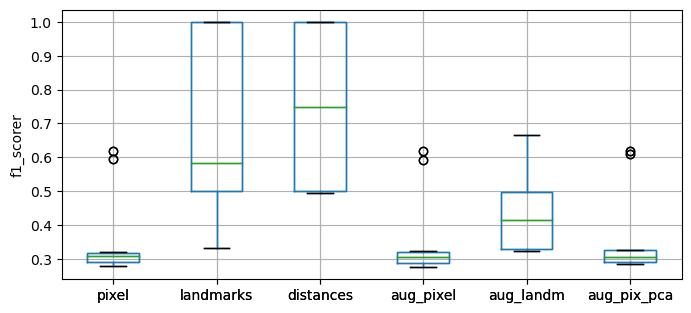

Mean accuracy scores:
'pixel':  0.83264630723472
'landmarks':  0.9947368421052631
'distances':  0.9947459557985874
'aug_pixel':  0.8315827788649707
'aug_landm':  0.9786667942497551
'aug_pix_pca':  0.8446126549249837

Mean f1 scores:
'pixel':  0.36079305134840434
'landmarks':  0.6984722731809497
'distances':  0.7483032459452661
'aug_pixel':  0.36010539399838376
'aug_landm':  0.4449629735370107
'aug_pix_pca':  0.36366711931145074

Mean score time:
'pixel':  0.18511736392974854
'landmarks':  0.05470559597015381
'distances':  0.039153552055358885
'aug_pixel':  2.6259005069732666
'aug_landm':  0.17348926067352294
'aug_pix_pca':  0.7663086891174317


In [68]:
from sklearn.neighbors import KNeighborsClassifier

pixel_accuracies = []
landmarks_accuracies = []
distances_accuracies = []
aug_pixel_accuracies = []
aug_landm_accuracies = []
aug_pix_pca_accuracies = []

for k in range(1, 11):
    print("\n\nTest for k = ", k)
    knn  = KNeighborsClassifier(n_neighbors = k)
    results_list = test_classifier(knn, X_list, y_list)
    plot_results(results_list)
    pixel_accuracies.append(results_list[0]['test_accuracy'])
    landmarks_accuracies.append(results_list[1]['test_accuracy'])
    distances_accuracies.append(results_list[2]['test_accuracy'])
    aug_pixel_accuracies.append(results_list[3]['test_accuracy'])
    aug_landm_accuracies.append(results_list[4]['test_accuracy'])
    aug_pix_pca_accuracies.append(results_list[5]['test_accuracy'])
    
    


 pixel


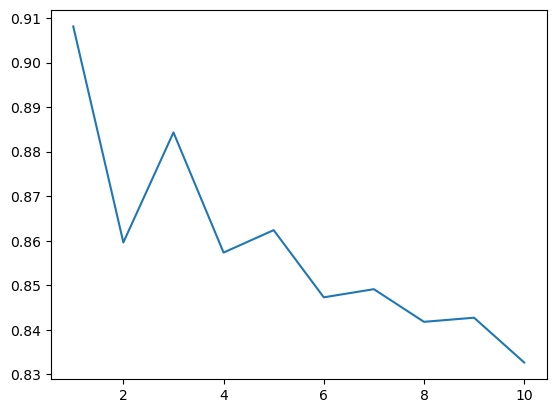


 landmarks


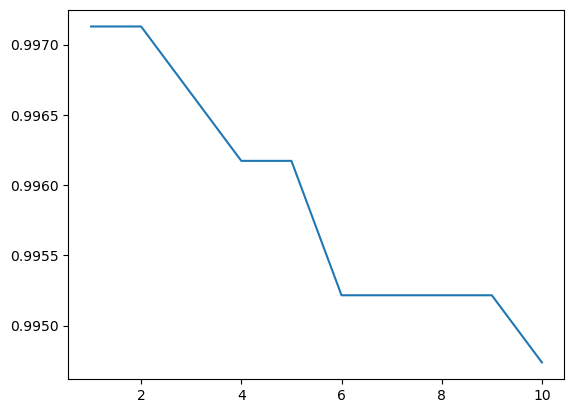


 distances


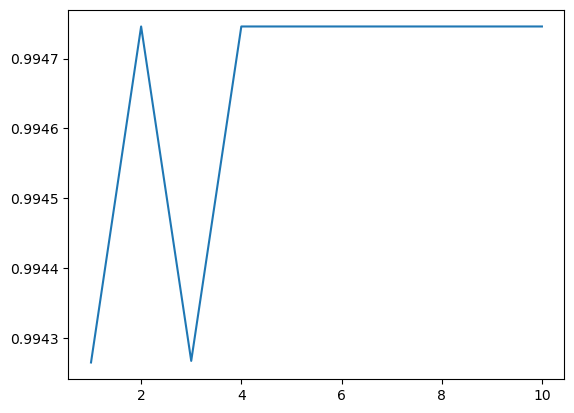


 aug_pixel


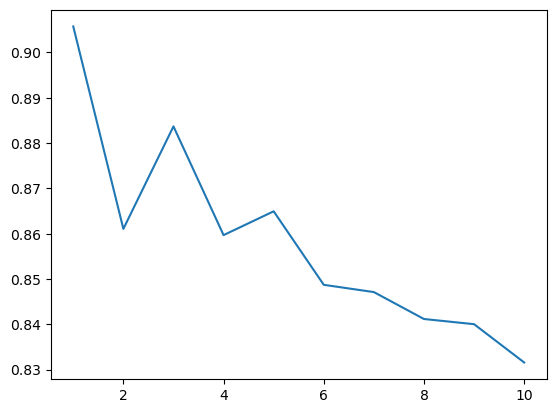


 aug_landm


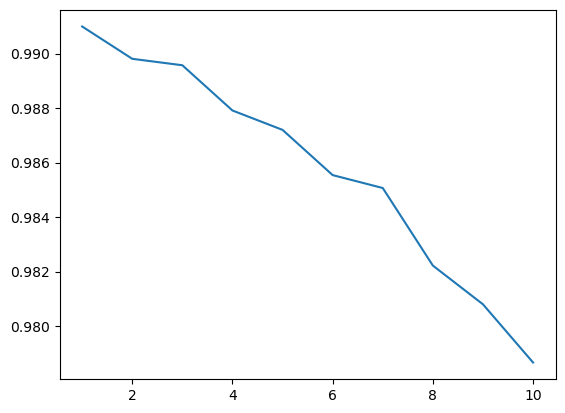


 aug_pix_pca


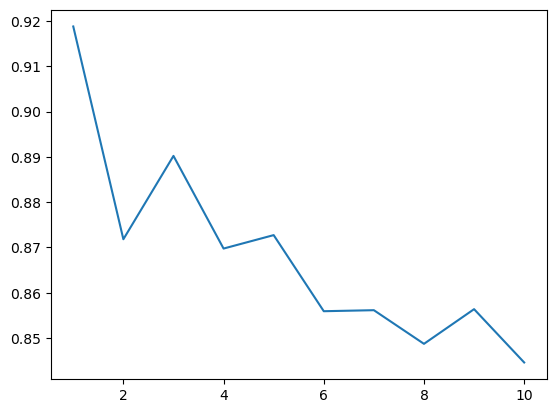

In [71]:
#plot accuracy trend changing k

list = []
list.append(pixel_accuracies)
list.append(landmarks_accuracies)
list.append(distances_accuracies)
list.append(aug_pixel_accuracies)
list.append(aug_landm_accuracies)
list.append(aug_pix_pca_accuracies)

count = 0
for list_elem in list:
    print('\n', techniques[count])
    mean_list = []
    for array in list_elem:
        mean_list.append(mean(array))
    plt.plot(range(1, 11), mean_list)
    plt.show()
    count = count + 1

An unusual thing happened with this classifier, for any dataset used, the accuracy decreases as the parameter k increases. Except for the dataset with distances, for the latter the accuracy remains constant with 3 < k < 10. The best value for the parameter k is 1

## Naive Bayesian

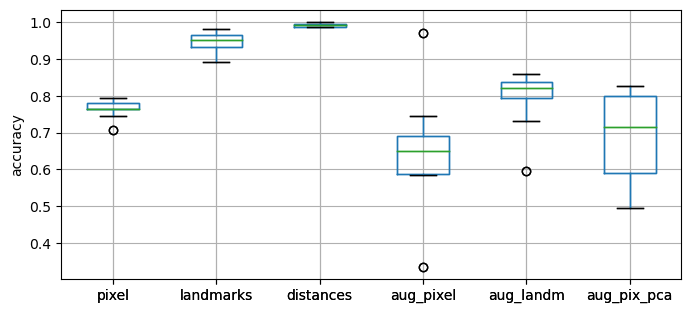

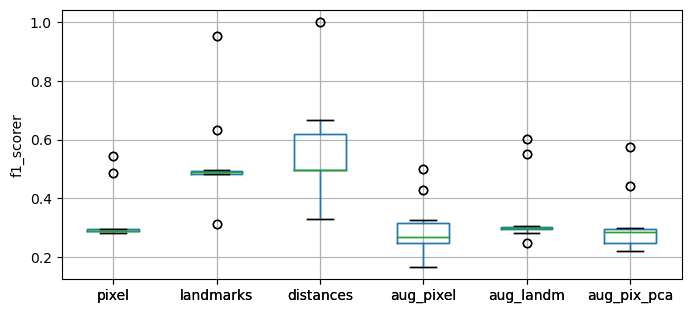

Mean accuracy scores:
'pixel':  0.7637132922793347
'landmarks':  0.9449874686716792
'distances':  0.9913943950786056
'aug_pixel':  0.6490087410306589
'aug_landm':  0.7933198995846045
'aug_pix_pca':  0.6932433137638617

Mean f1 scores:
'pixel':  0.3352437449529858
'landmarks':  0.5317179828105127
'distances':  0.5643911915710057
'aug_pixel':  0.2996738498626803
'aug_landm':  0.34876738647726835
'aug_pix_pca':  0.316184544577926

Mean score time:
'pixel':  0.041062664985656736
'landmarks':  0.01169881820678711
'distances':  0.010998702049255371
'aug_pixel':  0.09860453605651856
'aug_landm':  0.014199614524841309
'aug_pix_pca':  0.06800870895385742


In [72]:
from sklearn.naive_bayes import GaussianNB
gc = GaussianNB()

results_list = test_classifier(gc, X_list, y_list);
plot_results(results_list)

pixel


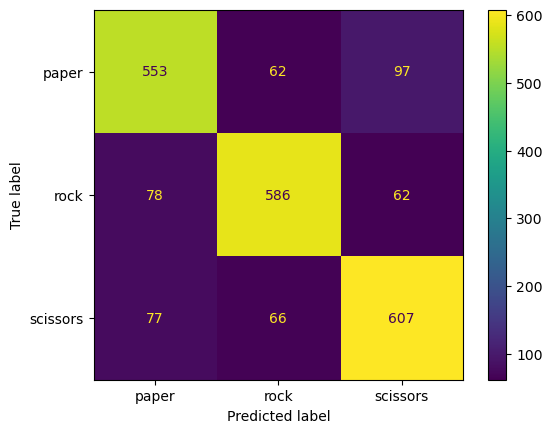

landmarks


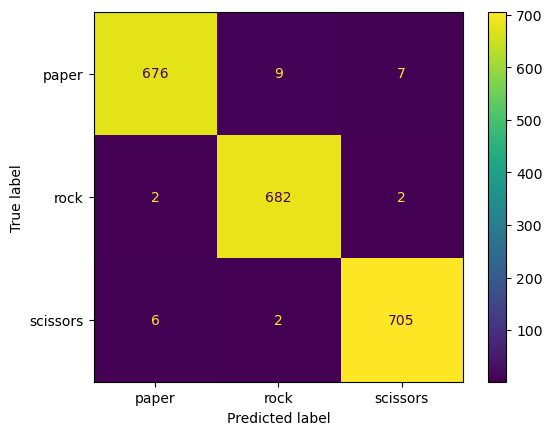

distances


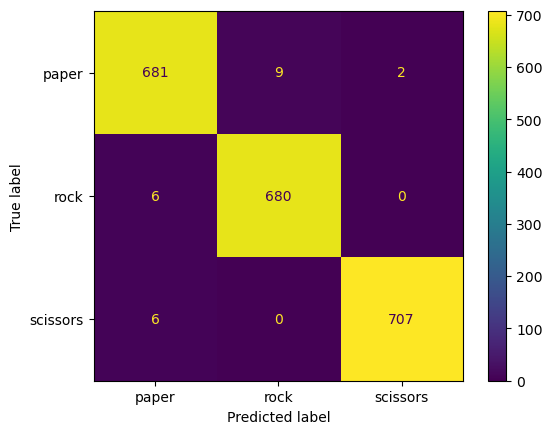

aug_pixel


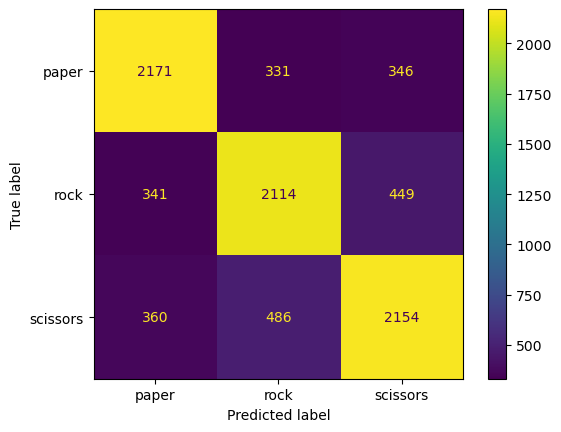

aug_landm


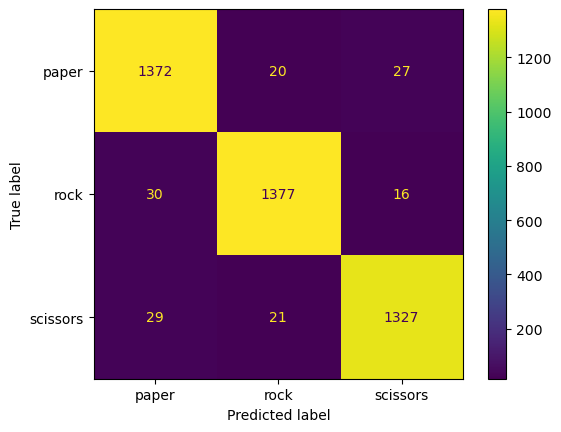

aug_pix_pca


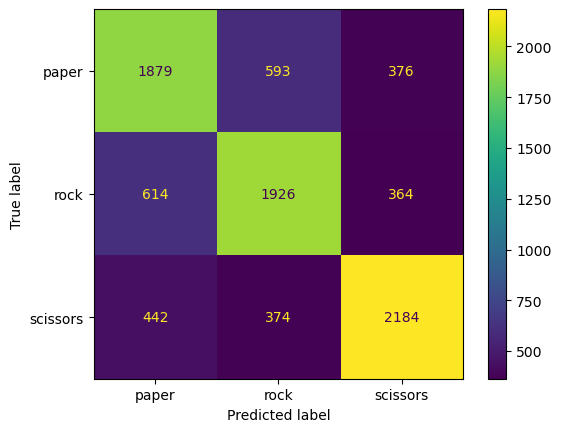

In [73]:
plot_confusion_matrix(gc, X_list, y_list)

## Random Forest Classifier
### n_estimators = 50

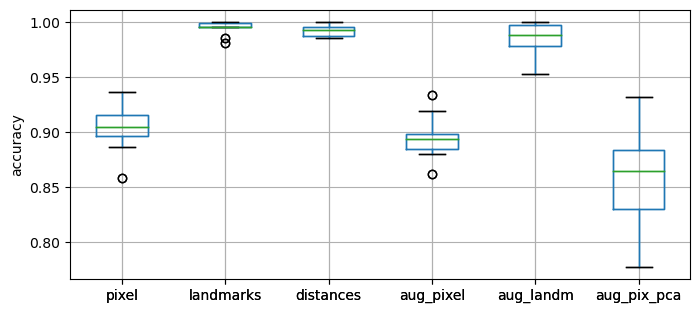

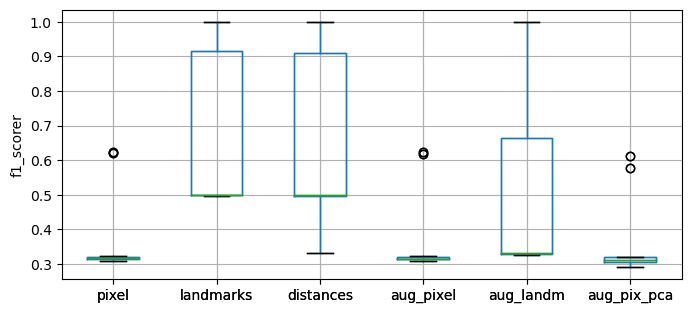

Mean accuracy scores:
'pixel':  0.9026643207238909
'landmarks':  0.9942583732057416
'distances':  0.9923513328776487
'aug_pixel':  0.8947671232876713
'aug_landm':  0.985538832164447
'aug_pix_pca':  0.8574054794520548

Mean f1 scores:
'pixel':  0.3774772922790044
'landmarks':  0.664973372921876
'distances':  0.6474579337717182
'aug_pixel':  0.37554752497295074
'aug_landm':  0.5302684618634061
'aug_pix_pca':  0.36499454552291444

Mean score time:
'pixel':  0.042006397247314455
'landmarks':  0.025304412841796874
'distances':  0.02390279769897461
'aug_pixel':  0.07920694351196289
'aug_landm':  0.028102731704711913
'aug_pix_pca':  0.0850083589553833


In [75]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 50)
results_list = test_classifier(rf, X_list, y_list);
plot_results(results_list)

pixel


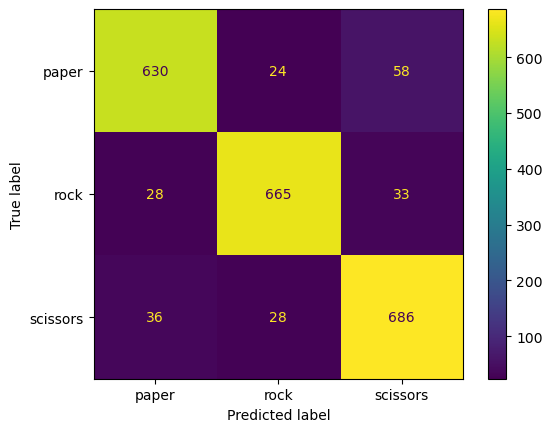

landmarks


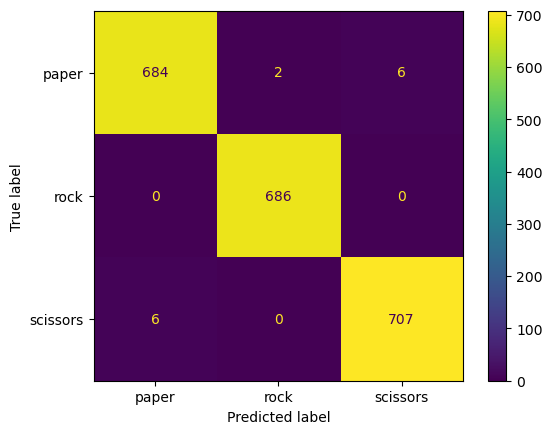

distances


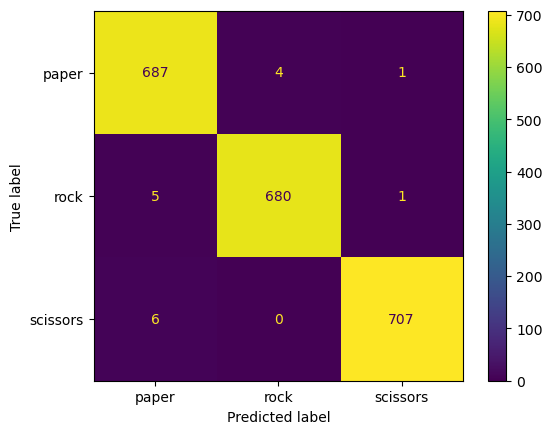

aug_pixel


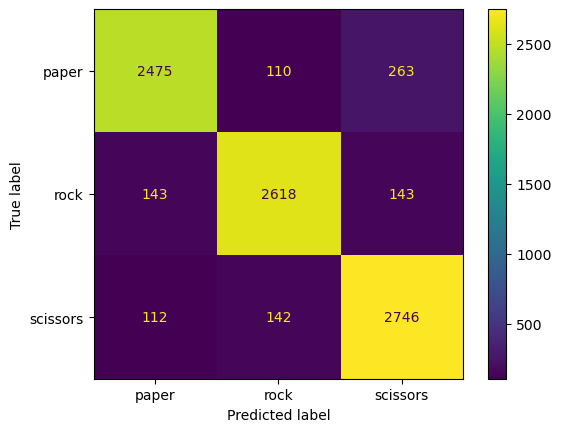

aug_landm


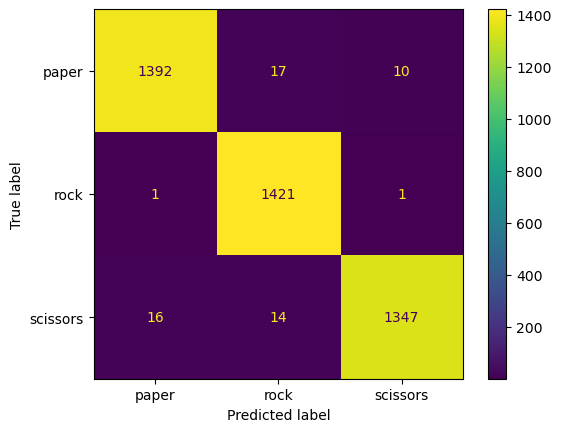

aug_pix_pca


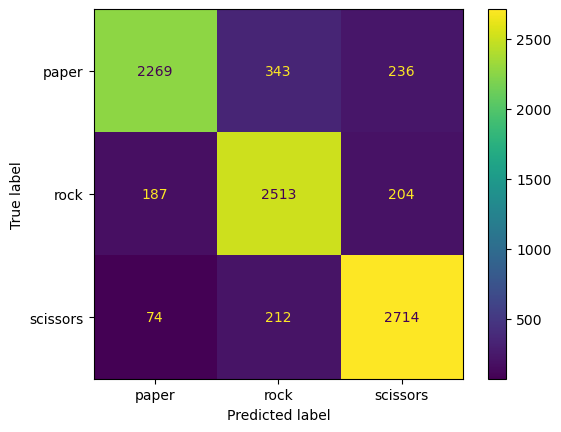

In [74]:
plot_confusion_matrix(rf, X_list, y_list)

## Random Forest Classifier
### n_estimators = 100

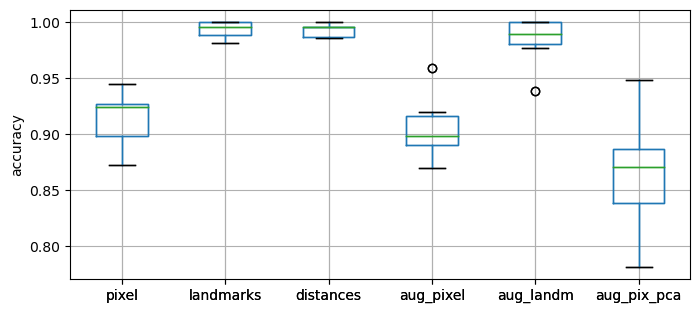

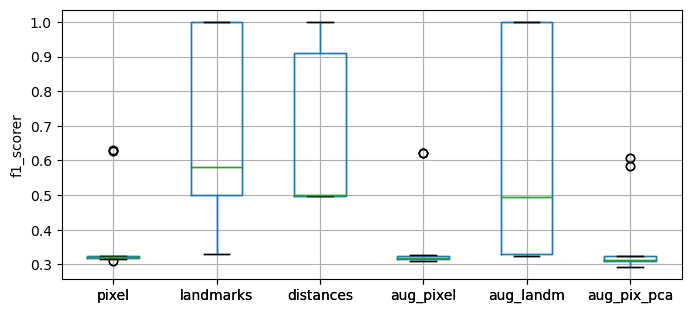

Mean accuracy scores:
'pixel':  0.9140966025721586
'landmarks':  0.9937799043062201
'distances':  0.9928298017771702
'aug_pixel':  0.9036803652968036
'aug_landm':  0.9857769247222253
'aug_pix_pca':  0.865173385518591

Mean f1 scores:
'pixel':  0.38054248930382906
'landmarks':  0.6985904508381651
'distances':  0.6641649527719027
'aug_pixel':  0.37745762783513287
'aug_landm':  0.6302343791652687
'aug_pix_pca':  0.3666290480666409

Mean score time:
'pixel':  0.055503344535827635
'landmarks':  0.04020414352416992
'distances':  0.03890359401702881
'aug_pixel':  0.12120974063873291
'aug_landm':  0.04080433845520019
'aug_pix_pca':  0.11961042881011963


In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100)
results_list = test_classifier(rf, X_list, y_list);
plot_results(results_list)

pixel


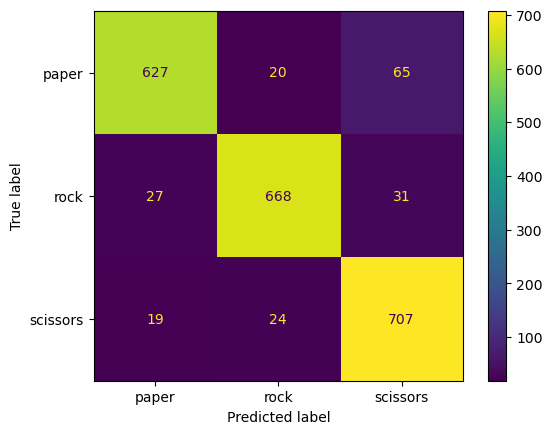

landmarks


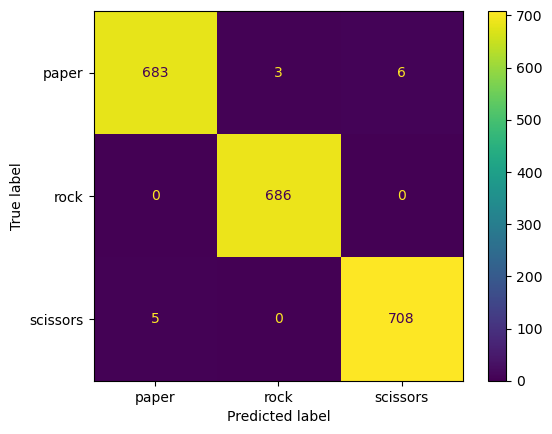

distances


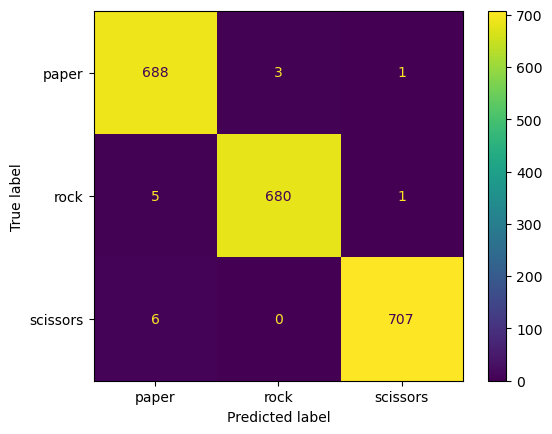

aug_pixel


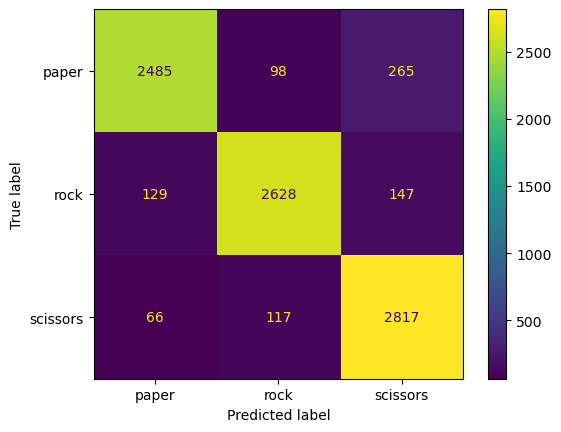

aug_landm


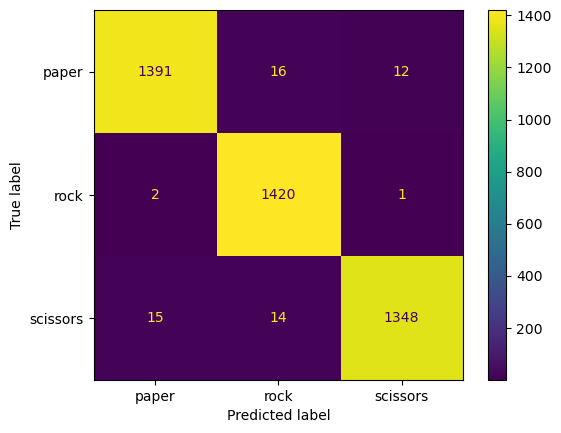

aug_pix_pca


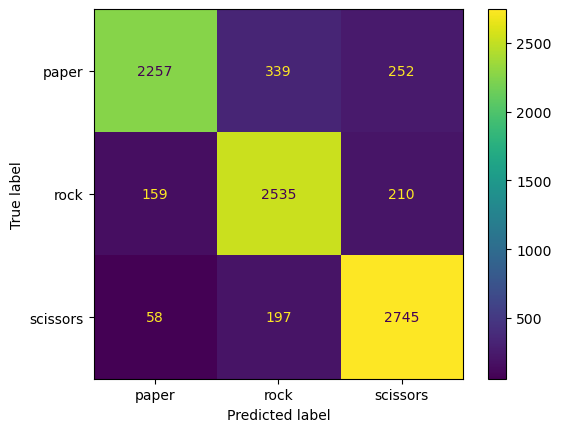

In [77]:
plot_confusion_matrix(rf, X_list, y_list)

## Classification Report

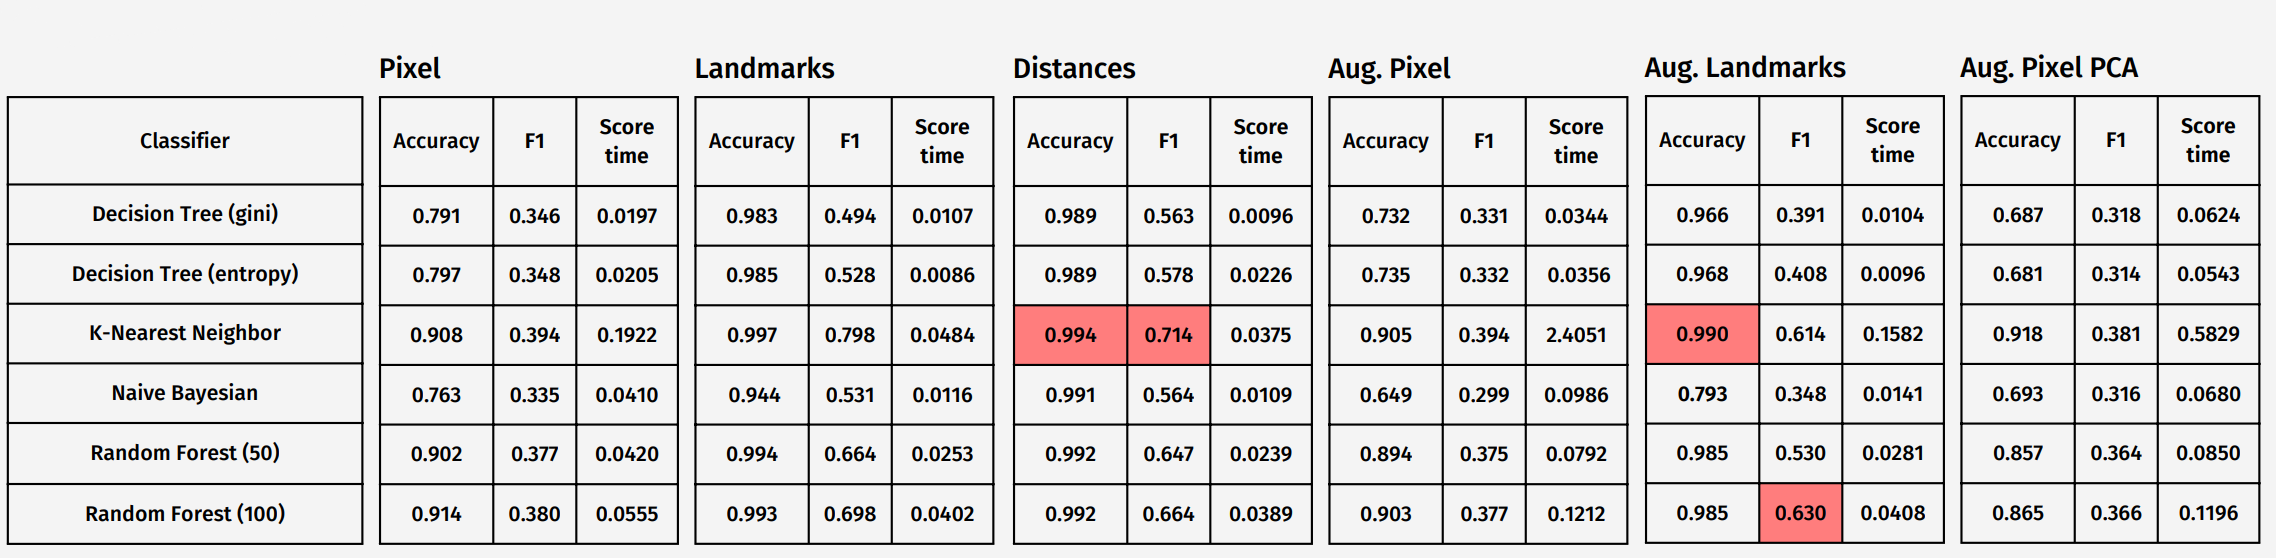

# Exporting Models for the Implementation

The best classifier for the distances Dataset is the K-Nearest Neighbor with k = 1, best both in terms of accuracy and f1 score. Also for the augmented dataset that has landmarks as features the best in term of accuracy is the K-Nearest Neighbor, in this case, however, the best for the f1 score is RandomForest (n_estimator = 100). I choose RandomForest because it is faster in classification. I have not implemented models that work with pixels because they are not general enough, probably a greenscreen is needed to be used.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

knn_distances = KNeighborsClassifier(n_neighbors = 1)
rf_aug_landmarks = RandomForestClassifier(n_estimators = 100)

knn_distances.fit(X_list[2], y_list[2])
rf_aug_landmarks.fit(X_list[4], y_list[4])

print(knn_distances.n_features_in_)
print(rf_aug_landmarks.n_features_in_)

5
42


In [20]:
import joblib
joblib.dump(knn_distances, "C:/Users/matte/PycharmProjects/pythonProject1/models/knn_distances.pkl");
joblib.dump(rf_aug_landmarks, "C:/Users/matte/PycharmProjects/pythonProject1/models/rf_aug_landmarks.pkl");